f=1, g=0, crack: 45 degrees

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# Settings
torch.set_default_dtype(torch.float64)   # use double for better derivative precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Domain: square [-1,1]^2 with crack along y=x starting from origin
X_MIN, X_MAX = -1.0, 1.0
Y_MIN, Y_MAX = -1.0, 1.0

# Training hyperparams
N_f = 4000       # collocation points
N_b_outer = 800  # boundary points on outer square
N_b_crack = 300  # boundary points on crack 
epochs = 250
#lr = 1e-3
lambda_bc = 1.0   # weight for BC loss

def compute_phi(x, y):
    r = torch.sqrt(x**2 + y**2)
    return torch.sqrt((2 ** 0.5 /4) * (2 ** 0.5 *r - (x+y)))


def compute_phi_derivs(x, y):
    r = torch.sqrt(x**2 + y**2)
    den = torch.sqrt(2*r - 2**0.5*(x+y)) 
    phi_x = (x/(2*r)-(2 ** 0.5 /4)) / den
    phi_y = (x/(2*r)-(2 ** 0.5 /4)) / den

    return phi_x.reshape(-1,1), phi_y.reshape(-1,1)

In [45]:
# Neural network 
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh
        # init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, inp):
        z = inp
        for layer in self.net[:-1]:
            z = self.activation(layer(z))
        z = self.net[-1](z)  # no activation on last
        return z

In [46]:
# Derivative 
def partials_U_wrt_inputs(model, x, y, phi):
    phi_det = phi.detach()  # ???ensure phi treated as independent input to U???
    inp = torch.cat([x, y, phi_det], dim=1).to(device) 
    inp.requires_grad_(True) #???

    U = model(inp)  # (N,1)

    grads = torch.autograd.grad(U, inp, grad_outputs=torch.ones_like(U), create_graph=True, retain_graph=True)[0]  # (N,3)
    U_x = grads[:,0:1]
    U_y = grads[:,1:2]
    U_z = grads[:,2:3]
    return U, inp, U_x, U_y, U_z

def second_partials_U(model, inp, U_x, U_y, U_z):
    grad_Ux = torch.autograd.grad(U_x, inp, grad_outputs=torch.ones_like(U_x), create_graph=True, retain_graph=True)[0]
    grad_Uy = torch.autograd.grad(U_y, inp, grad_outputs=torch.ones_like(U_y), create_graph=True, retain_graph=True)[0]
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z), create_graph=True, retain_graph=True)[0]

    U_xx = grad_Ux[:,0:1]
    #U_xy = grad_Ux[:,1:2]
    U_xz = grad_Ux[:,2:3]

    #U_yx = grad_Uy[:,0:1]
    U_yy = grad_Uy[:,1:2]
    U_yz = grad_Uy[:,2:3]

    #U_zx = grad_Uz[:,0:1]
    #U_zy = grad_Uz[:,1:2]
    U_zz = grad_Uz[:,2:3]

    return U_xx, U_yy, U_xz, U_yz, U_zz

def compute_laplace_uN(model, x, y):
    phi = compute_phi(x, y)
    phi_x, phi_y = compute_phi_derivs(x, y)
    U, inp, U_x, U_y, U_z = partials_U_wrt_inputs(model, x, y, phi)
    U_xx, U_yy, U_xz, U_yz, U_zz = second_partials_U(model, inp, U_x, U_y, U_z)
    laplace_xU = U_xx + U_yy
    r = torch.sqrt(x**2 + y**2)
    lap = laplace_xU + 2*(U_xz * phi_x + U_yz * phi_y) + torch.sqrt(phi_x**2 + phi_y**2) * U_zz

    return lap  # shape (N,1)

In [47]:
def sample_collocation(N):
    x = torch.rand(N*2,1) * (X_MAX - X_MIN) + X_MIN
    y = torch.rand(N*2,1) * (Y_MAX - Y_MIN) + Y_MIN

    # remove points on crack: from (0,0) to (1,1)
    mask_crack = (torch.abs(y - x) < 1e-8) & (x >= 0.0) & (y >= 0.0)
    mask = ~mask_crack

    x = x[mask][:N]
    y = y[mask][:N]
    return x.view(-1,1).to(device), y.view(-1,1).to(device)


def sample_outer_boundary(N):
    per_side = max(4, N // 4)
    xs, ys = [], []
    # left (x=-1)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1))
    xs.append(torch.ones_like(ys[-1]) * X_MIN)
    # right (x=1)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1))
    xs.append(torch.ones_like(ys[-1]) * X_MAX)
    # bottom (y=-1)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1))
    ys.append(torch.ones_like(xs[-1]) * Y_MIN)
    # top (y=1)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1))
    ys.append(torch.ones_like(xs[-1]) * Y_MAX)

    x = torch.cat(xs, dim=0)[:N]
    y = torch.cat(ys, dim=0)[:N]
    return x.view(-1,1).to(device), y.view(-1,1).to(device)

def sample_crack_boundary(N):
    t_vals = torch.linspace(0, 1, N + 1, device=device)[1:].unsqueeze(1)  # 均勻分布在(0,1]
    x_vals = t_vals
    y_vals = t_vals
    return x_vals, y_vals

#def sample_crack_boundary(N):
#    t_vals = torch.linspace(0, 1, N, device=device).unsqueeze(1)  # 均勻分布在(0,1]
#    x_vals = t_vals
#    y_vals = t_vals
#    return x_vals, y_vals

#  model
layers = [3, 64, 1]  
model = MLP(layers).to(device)

# Training data
x_f, y_f = sample_collocation(N_f)
x_b_out, y_b_out = sample_outer_boundary(N_b_outer)
x_b_crack, y_b_crack = sample_crack_boundary(N_b_crack)

with torch.no_grad():
    g_b_out = torch.zeros_like(x_b_out, device=device)
    g_b_crack = torch.zeros_like(x_b_crack, device=device)

# concatenate all boundary points
x_b = torch.cat([x_b_out, x_b_crack], dim=0)
y_b = torch.cat([y_b_out, y_b_crack], dim=0)
g_b = torch.cat([g_b_out, g_b_crack], dim=0)

loss_history = []

In [48]:
optimizer = optim.LBFGS(model.parameters(), lr=1.0, max_iter=20, history_size=50, line_search_fn="strong_wolfe")

print("Start training with LBFGS on device:", device)

for ep in range(epochs):

    def closure():
        optimizer.zero_grad()
        # PDE loss
        lap_u = compute_laplace_uN(model, x_f, y_f)  # shape (N_f,1)
        residual = -lap_u-1  # f=1
        loss_pde = torch.mean(residual**2)

        # boundary loss
        phi_b = compute_phi(x_b, y_b)
        inp_bc = torch.cat([x_b, y_b, phi_b.detach()], dim=1)
        u_bc = model(inp_bc)
        loss_bc = torch.mean((u_bc - g_b)**2)

        loss = loss_pde + lambda_bc * loss_bc
        loss.backward()
        return loss

    loss = optimizer.step(closure)   # closure 被 optimizer 多次呼叫

    loss_history.append(loss.item())

    if ep % 1 == 0 or ep == epochs-1:
        print(f"Epoch {ep:5d} | Loss {loss.item():.3e}")

print("Training finished.")

Start training with LBFGS on device: cpu
Epoch     0 | Loss 1.030e+00
Epoch     1 | Loss 1.430e-02
Epoch     2 | Loss 3.790e-03
Epoch     3 | Loss 2.596e-03
Epoch     4 | Loss 2.114e-03
Epoch     5 | Loss 1.857e-03
Epoch     6 | Loss 1.531e-03
Epoch     7 | Loss 1.264e-03
Epoch     8 | Loss 1.034e-03
Epoch     9 | Loss 8.577e-04
Epoch    10 | Loss 7.705e-04
Epoch    11 | Loss 6.371e-04
Epoch    12 | Loss 5.588e-04
Epoch    13 | Loss 4.843e-04
Epoch    14 | Loss 4.472e-04
Epoch    15 | Loss 3.614e-04
Epoch    16 | Loss 3.367e-04
Epoch    17 | Loss 2.801e-04
Epoch    18 | Loss 2.587e-04
Epoch    19 | Loss 2.274e-04
Epoch    20 | Loss 2.090e-04
Epoch    21 | Loss 1.861e-04
Epoch    22 | Loss 1.696e-04
Epoch    23 | Loss 1.546e-04
Epoch    24 | Loss 1.414e-04
Epoch    25 | Loss 1.246e-04
Epoch    26 | Loss 1.131e-04
Epoch    27 | Loss 1.044e-04
Epoch    28 | Loss 9.697e-05
Epoch    29 | Loss 8.281e-05
Epoch    30 | Loss 7.418e-05
Epoch    31 | Loss 6.654e-05
Epoch    32 | Loss 6.201e-05
Ep

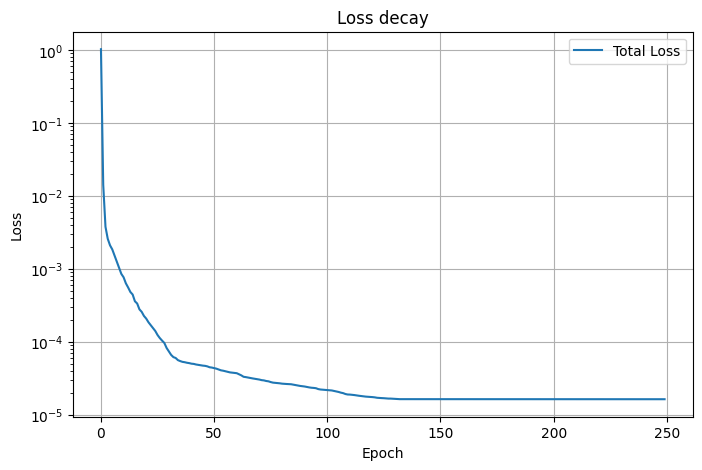

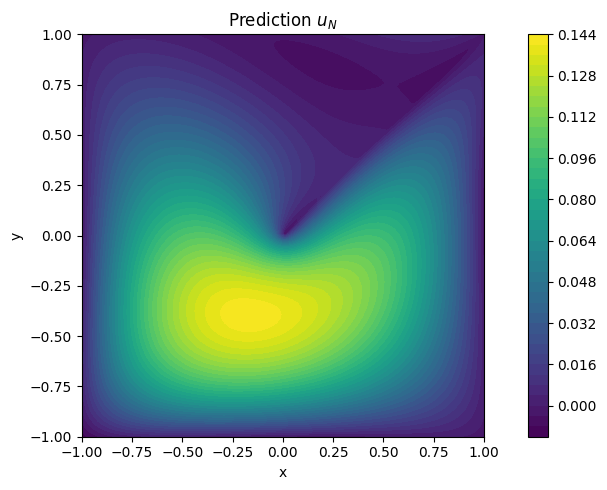

In [49]:
# 畫 Loss
plt.figure(figsize=(8,5))
plt.semilogy(loss_history, label='Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss decay")
plt.grid(True)
plt.show()

# 測試網格
nx = 100
xs = np.linspace(X_MIN, X_MAX, nx)
ys = np.linspace(Y_MIN, Y_MAX, nx)
Xg, Yg = np.meshgrid(xs, ys)
x_grid = torch.from_numpy(Xg.flatten()[:,None]).to(device).double()
y_grid = torch.from_numpy(Yg.flatten()[:,None]).to(device).double()

# phi(grid)
with torch.no_grad():
    phi_grid = compute_phi(x_grid, y_grid)

# 預測解
with torch.no_grad():
    inp_grid = torch.cat([x_grid, y_grid, phi_grid], dim=1)
    u_pred = model(inp_grid).cpu().numpy().reshape(nx, nx)

# 畫圖 
fig, ax = plt.subplots(figsize=(9,5))  

im0 = ax.contourf(Xg, Yg, u_pred, 50, cmap='viridis')
fig.colorbar(im0, ax=ax)
ax.set_title('Prediction $u_N$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')  #x, y 軸比例相同

plt.tight_layout()
plt.show()